In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
import pickle
import time
from collections import defaultdict
import sys
path = "../data/"
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 140
plt.rcParams["axes.labelsize"] = 14

#np.random.seed(250)
nlp = spacy.load("en_core_sci_lg", disable=['ner', 'parser'])

In [2]:
import numpy as np
import spacy
from tqdm import tqdm
from collections import defaultdict

path = "../data/"

def tokenize(string):
    doc = nlp.make_doc(string)
    words = [doc[i].text.lower()  for i in range(len(doc)) if 
             doc[i].is_alpha and not doc[i].is_stop]
    mn = 2
    ngrams= [' '.join(words[i:i+n]) for n in range(1, mn+1) for i in range(len(words)-n+1)]
    #words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop and len(token.text) > 1 ]
    return ngrams

def tokenization(train_data):
    tokenized_texts = []
    #print("Tokenization....")
    for _, row in train_data.iterrows():
        #text = str(row['Abstract']) + str(row["Title"])
        text = str(row['review'])
        words = tokenize(text)
        tokenized_texts.append(words)
    return tokenized_texts

# TFIDF (Term frequency and inverse document frequency)
def get_word_stat(tokenized_texts):
    '''Words counts in documents
    finds in how many documents this word
    is present
    '''
    texts_number = len(tokenized_texts)
    #print("Word Stat....")
    word2text_count = defaultdict(int)
    for text in tokenized_texts:
        uniquewords = set(text)
        for word in uniquewords:
            word2text_count[word] +=1
    return word2text_count

def get_doc_tfidf(words, word2text_count, N):
    num_words = len(words)
    word2tfidf = defaultdict(int)
    for word in words:
        if word2text_count[word] > 0:
            idf = np.log(N/(word2text_count[word]))
            word2tfidf[word] += (1/num_words) * idf
        else:
            word2tfidf[word] = 1
    return word2tfidf

def create_pmi_dict(tokenized_texts, targets, min_count=5):
    #print("PMI dictionary ....")
    np.seterr(divide = 'ignore')
    # words count
    d = {0:defaultdict(int), 1:defaultdict(int), 'tot':defaultdict(int)}
    for idx, words in enumerate(tokenized_texts):
        target = targets[idx]
        for w in words:
            d[ target ][w] += 1
    Dictionary = set(list(d[0].keys()) + list(d[1].keys()))
    d['tot'] = {w:d[0][w] + d[1][w] for w in Dictionary}
    # pmi calculation
    N_0 = sum(d[0].values())
    N_1 = sum(d[1].values())
    d[0] = {w: -np.log((v/N_0 + 10**(-15)) / (0.5 * d['tot'][w]/(N_0 + N_1))) / np.log(v/N_0 + 10**(-15))
            for w, v in d[0].items() if d['tot'][w] > min_count}
    d[1] = {w: -np.log((v/N_1+ 10**(-15)) / (0.5 * d['tot'][w]/(N_0 + N_1))) / np.log(v/N_1 + 10**(-15))
            for w, v in d[1].items() if d['tot'][w] > min_count}
    del d['tot']
    return d


def calc_collinearity(word, words_dict, n=10):
    new_word_emb = nlp(word).vector
    pmi_new = 0
    max_pmis_words = sorted(list(words_dict.items()), key=lambda x: x[1], reverse=True)[:n]
    for w, pmi in max_pmis_words:
        w_emb = nlp(w).vector
        cos_similarity = \
        np.dot(w_emb, new_word_emb)/(np.linalg.norm(w_emb) * np.linalg.norm(new_word_emb) + 1e-12)
        pmi_new += cos_similarity * pmi
    return pmi_new / n


def create_tot_pmitfidf(words, words_pmis, word2tfidf):
    tot_pmitfidf0 = []
    tot_pmitfidf1 = []
    for word in words:
        if word in words_pmis[0]:
            tot_pmitfidf0.append( words_pmis[0][word] * word2tfidf[word] )
        else:
            pmi0idf = pmiidf_net.forward( nlp(word).vector )
            #pmi0 = calc_collinearity(word, words_pmis[0])
            tot_pmitfidf0.append( pmi0 )
        if word in words_pmis[1]:
            tot_pmitfidf1.append( words_pmis[1][word] * word2tfidf[word] )
        else:
            pmi1 = calc_collinearity(word, words_pmis[1])
            tot_pmitfidf1.append( pmi1 )

    return tot_pmitfidf0, tot_pmitfidf1


def classify_pmi_based(words_pmis, word2text_count, tokenized_test_texts, N):
    results = np.zeros(len(tokenized_test_texts))
    for idx, words in enumerate(tokenized_test_texts):
        word2tfidf = get_doc_tfidf(words, word2text_count, N)
        # PMI - determines significance of the word for the class
        # TFIDF - determines significance of the word for the document
        #tot_pmi0, tot_pmi1 = create_tot_pmitfidf(words, words_pmis, word2tfidf)
        tot_pmi0 = [ words_pmis[0][w] * word2tfidf[w] for w in set(words) if w in words_pmis[0] ]
        tot_pmi1 = [ words_pmis[1][w] * word2tfidf[w] for w in set(words) if w in words_pmis[1] ]
        pmi0 = np.sum(tot_pmi0)
        pmi1 = np.sum(tot_pmi1)
        diff = pmi1 - pmi0
        if diff > 0.001:
            results[idx] = 1
    return results

In [3]:
data_raw = pd.read_csv(path + 'IMDB_Dataset.csv')
indices = np.random.permutation(data_raw.index)
data = data_raw.loc[indices]
data = data_raw.sample(frac=1)
data = data.replace(to_replace=['negative', 'positive'], value=[0, 1])

In [4]:
idx = int(data.shape[0] * 0.1)
test_data = data.iloc[:idx]
train_data = data.iloc[idx:]
targets_train = train_data["sentiment"].values
targets_test = test_data["sentiment"].values

In [5]:
tokenized_texts = tokenization(train_data)
tokenized_test_texts = tokenization(test_data)
N = len(tokenized_texts)

In [6]:
word2text_count = get_word_stat(tokenized_texts)
words_pmis = create_pmi_dict(tokenized_texts, targets_train, min_count=5)
results = classify_pmi_based(words_pmis, word2text_count, tokenized_test_texts, N)
precision = np.sum( np.logical_and(results, targets_test) ) / np.sum(results)
recall = np.sum( np.logical_and(results, targets_test) ) / np.sum(targets_test)
F1 = 2 * (recall * precision)/(recall + precision)
accuracy = (results == targets_test).mean()

In [56]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", F1)

Accuracy:  0.9183098591549296
Precision:  0.8944591029023746
Recall:  0.9495798319327731
F1:  0.921195652173913


In [52]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", F1)

Accuracy:  0.9211267605633803
Precision:  0.8981481481481481
Recall:  0.9509803921568627
F1:  0.9238095238095237


In [48]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", F1)

Accuracy:  0.9274647887323944
Precision:  0.9190672153635117
Recall:  0.938375350140056
F1:  0.9286209286209285


In [7]:
scores = {"accuracies":[], "precisions":[], "recalls":[], "F1s":[], "size":[]}
dict_size = [i for i in np.arange(0.02, 1, 0.01)]
for i in dict_size:
    part = tokenized_texts[:int(N * i)]
    scores["size"].append(len(part))
    word2text_count = get_word_stat(part)
    words_pmis = create_pmi_dict(part, targets_train, min_count=5)

    results = classify_pmi_based(words_pmis, word2text_count, tokenized_test_texts, N)

    precision = np.sum( np.logical_and(results, targets_test) ) / np.sum(results)
    recall = np.sum( np.logical_and(results, targets_test) ) / np.sum(targets_test)
    F1 = 2 * (recall * precision)/(recall + precision)

    accuracy = (results == targets_test).mean()
    scores["accuracies"].append( accuracy )
    scores["precisions"].append( precision )
    scores["recalls"].append( recall )
    scores["F1s"].append( F1 )

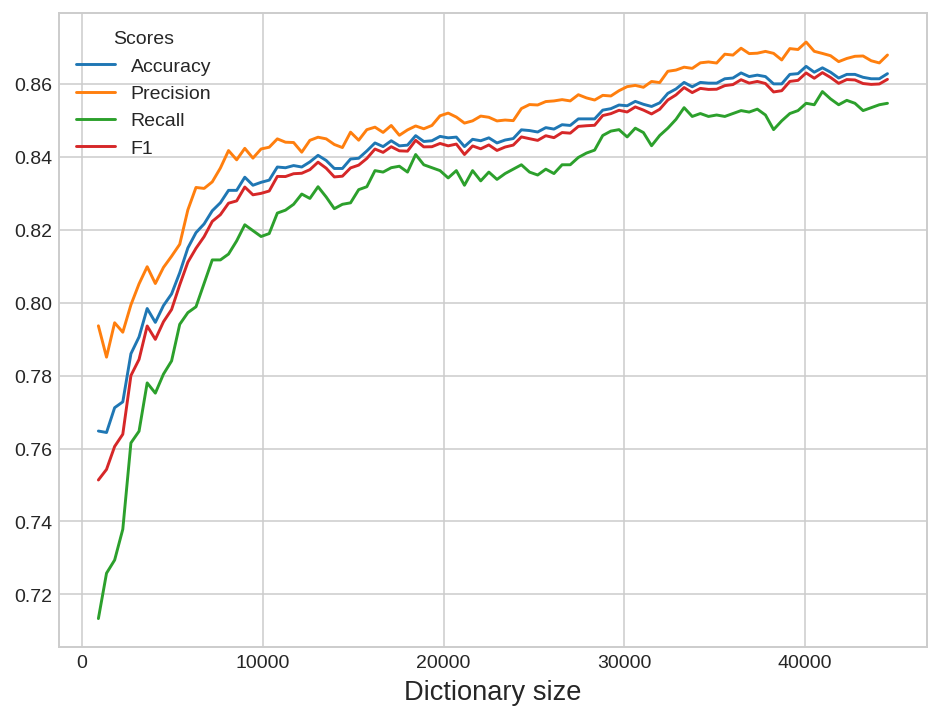

In [8]:
fig, axs = plt.subplots(1, 1)
axs.plot(scores["size"], scores["accuracies"], label="Accuracy")
axs.plot(scores["size"], scores["precisions"], label="Precision")
axs.plot(scores["size"], scores["recalls"], label="Recall")
axs.plot(scores["size"], scores["F1s"], label="F1")
axs.legend(title="Scores");
axs.set(xlabel="Dictionary size");
plt.savefig("score_dict_size_IMDB.png")

In [9]:
with open("scores_IMDB_ngrams.p", "wb") as file:
    pickle.dump(scores, file)

In [45]:
def create_dict(tokenized_texts, targets, min_count=5):
    np.seterr(divide = 'ignore')
    # words count
    d = {0:defaultdict(int), 1:defaultdict(int), 'tot':defaultdict(int)}
    for idx, words in enumerate(tokenized_texts):
        target = targets[idx]
        for w in words:
            d[ target ][w] += 1
    return d

In [48]:
dictionary_imdb = create_dict(tokenized_texts, targets_train, min_count=5)

In [49]:
with open("dict_IMDB.p", "wb") as file:
    pickle.dump(dictionary_imdb, file)